# Generating dimension reduction of just DC for visualisation

## Set up workspace

In [1]:
#load packages I need
import os
import tools
import scanpy as sc
import pandas as pd
import dandelion as ddl
from tqdm import tqdm
import matplotlib.pyplot as plt
import scanpy.external as sce
from matplotlib.pyplot import rc_context
import seaborn as sns

In [2]:
#set current directory 
os.chdir('/scratch/user/s4436039/scdata/Python_Integration_Sep')
os.getcwd()

'/scratch/user/s4436039/scdata/Python_Integration_Sep'

## Read in current, processed and clean atlas

In [3]:
# read in data
data = sc.read_h5ad('NRclean_clustered2.h5ad')

KeyboardInterrupt: 

In [4]:
data

AnnData object with n_obs × n_vars = 498023 × 1268
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology', 'cancer_type_broad', 'clean-leiden_0.8', 'clean-subcluster', 'clean-subcluster-v2', 'YS_sig', 'HSC_sig', 'CD5nDC2_up_vDC3', 'DC3_up_vCD5nDC2', 'CD5pDC2_up_vDC3', 'DC3_up_vCD5pDC2', 'DC3_up_vMono', 'Mono_up_vDC3', 'DC1_sig', 'DC2_sig', 'DC3_sig', 'DC_Axl_sig', 'DC2_up_DC3', 'DC3_up_DC2', 'mregDC_sig', 'cDC1_mregDC', 'cDC2_mregDC', 'NR_annotati

## Subset out the DCs

In [5]:
data_DC = data[data.obs["NR_annotations_simple"].isin(["cDC1","cDC2","mregDC"])]

# repeat neighbours and UMAP on DC

In [6]:
## Computing neighbourhood graph - here UMAP
sc.pp.neighbors(data_DC, n_neighbors=10, n_pcs=60)

In [7]:
sc.tl.umap(data_DC, min_dist=0.3)  

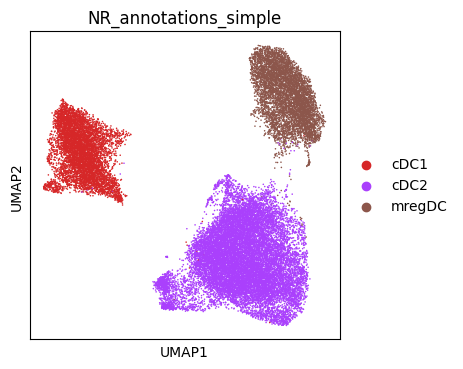

In [5]:
#plotting 
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(data, color=["NR_annotations_simple"], ncols=1, size=5)

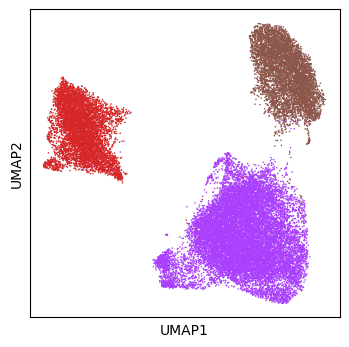

In [8]:
#plotting 
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(data, 
               color=["NR_annotations_simple"], 
               ncols=1, 
               size=5,
               title="",
               legend_loc='none'
               )

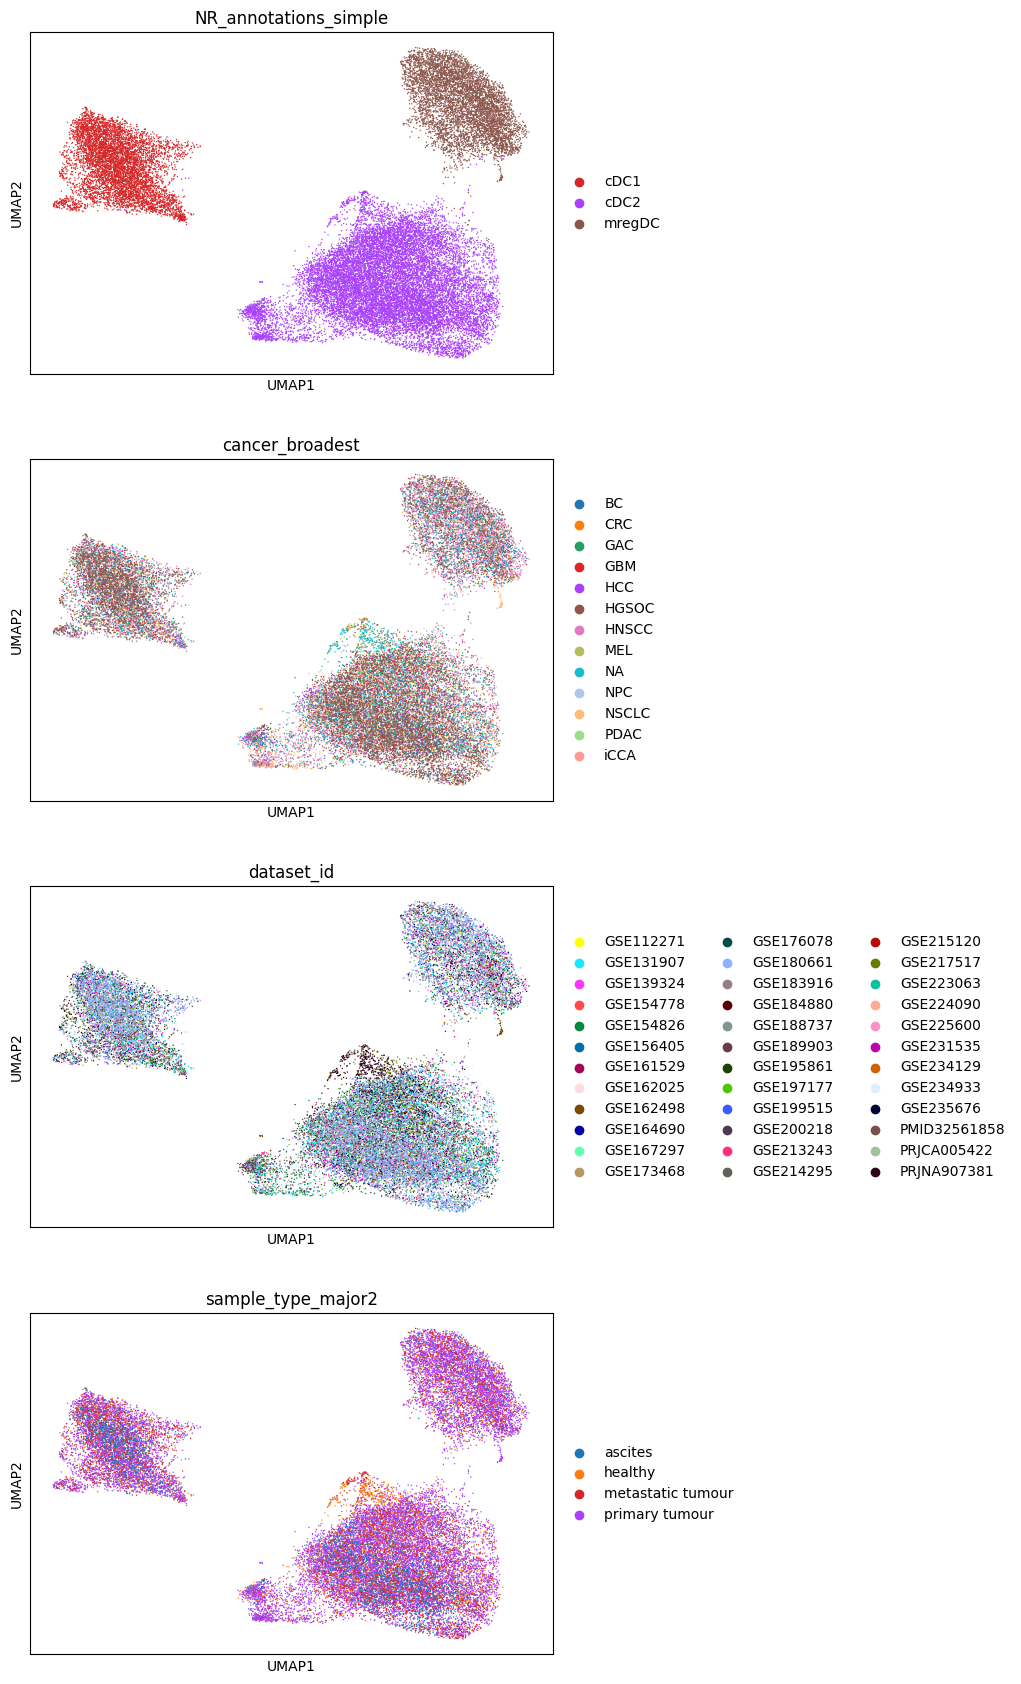

In [7]:
#visualise UMAP --> can see now integrated
sc.pl.umap(
    data_DC,
    color=[
        "NR_annotations_simple",
        "cancer_broadest",
        "dataset_id",
        "sample_type_major2"
    ],
    ncols=1,
)

# Export out DC alone

In [10]:
# Export out DC alone
data_DC.write_h5ad("NRclean_clustered2_DC.h5ad", compression="gzip")

In [4]:
# read in data
data = sc.read_h5ad('NRclean_clustered2_DC.h5ad')

In [5]:
# check 
type_counts = data.obs['NR_annotations_simple'].value_counts()
print(type_counts)

NR_annotations_simple
cDC2      17391
cDC1       6730
mregDC     6120
Name: count, dtype: int64


# Visualisation: 

## Calculate DEG genes between DC clusters

In [8]:
#calculate DEG genes:
sc.tl.rank_genes_groups(data, groupby="NR_annotations_simple", method="wilcoxon")

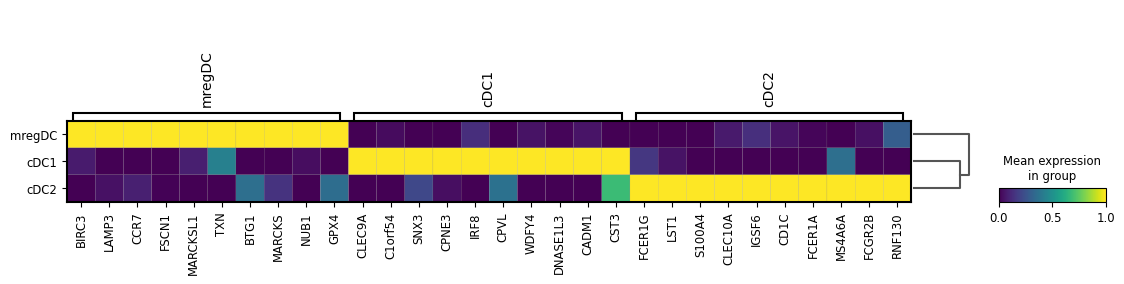

In [11]:
# visualise the top 10 DEG genes
sc.tl.dendrogram(data, groupby="NR_annotations_simple")
sc.pl.rank_genes_groups_matrixplot(data, groupby="NR_annotations_simple", standard_scale="var", n_genes=10, min_logfoldchange=1)

# Plot subsets as proportion of DCs by cancer type (plotting done on prism)

In [4]:
# create objects for sample types 
data_primary = data[data.obs["sample_type_major2"] == "primary tumour"]
data_mets = data[data.obs["sample_type_major2"] == "metastatic tumour"]
data_H = data[data.obs["sample_type_major2"] == "healthy"]
data_OC = data[data.obs["cancer_with_H"] == "HGSOC"]

## Primary tumour:

In [5]:
# Create a DataFrame containing just sample, subtype and annotations 
df = data_primary.obs[["integration_id", "cancer_broadest", "NR_annotations_simple"]].copy()

# Create a new column for each DC type, indicating whether each cell belongs to that type (True vs False)
df["is_cDC1"] = df["NR_annotations_simple"] == "cDC1"
df["is_cDC2"] = df["NR_annotations_simple"] == "cDC2"
df["is_mregDC"] = df["NR_annotations_simple"] == "mregDC"

# Calculate proportions of each DC type per sample within each cancer subtype
proportion_df = (
    df.groupby(["integration_id", "cancer_broadest"])[["is_cDC1", "is_cDC2", "is_mregDC"]] #groups dataframe by each unique combo of sample_id and cancer type, keeps the booleen columns 
    .mean() #calculating the mean of a booleen column gives the proportion of true values 
    .reset_index()
    .rename(columns={"is_cDC1": "cDC1_proportion", "is_cDC2": "cDC2_proportion", "is_mregDC": "mregDC_proportion"}) #rename eg. is_cDC1 column to cDC1_proportion
)

#now have a dataframe containing proportion of each DC type for every sample and cancer type
proportion_df.head(15)

/scratch/temp/12001575/ipykernel_945504/2000647374.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,integration_id,cancer_broadest,cDC1_proportion,cDC2_proportion,mregDC_proportion
0,GGSE223063_GLIO_1,BC,NaN,NaN,NaN
1,GGSE223063_GLIO_1,CRC,NaN,NaN,NaN
2,GGSE223063_GLIO_1,GAC,NaN,NaN,NaN
3,GGSE223063_GLIO_1,GBM,0.371795,0.487179,0.141026
4,GGSE223063_GLIO_1,HCC,NaN,NaN,NaN
5,GGSE223063_GLIO_1,HGSOC,NaN,NaN,NaN
6,GGSE223063_GLIO_1,HNSCC,NaN,NaN,NaN
7,GGSE223063_GLIO_1,MEL,NaN,NaN,NaN
8,GGSE223063_GLIO_1,NPC,NaN,NaN,NaN
9,GGSE223063_GLIO_1,NSCLC,NaN,NaN,NaN


In [6]:
# Melt the DataFrame to "long" format for seaborn plotting
proportion_df_long = proportion_df.melt(
    id_vars=["integration_id", "cancer_broadest"], 
    value_vars=["cDC1_proportion", "cDC2_proportion", "mregDC_proportion"],
    var_name="Cell_Type",
    value_name="Proportion"
)

proportion_df_long.head(15)

,integration_id,cancer_broadest,Cell_Type,Proportion
0,GGSE223063_GLIO_1,BC,cDC1_proportion,NaN
1,GGSE223063_GLIO_1,CRC,cDC1_proportion,NaN
2,GGSE223063_GLIO_1,GAC,cDC1_proportion,NaN
3,GGSE223063_GLIO_1,GBM,cDC1_proportion,0.371795
4,GGSE223063_GLIO_1,HCC,cDC1_proportion,NaN
5,GGSE223063_GLIO_1,HGSOC,cDC1_proportion,NaN
6,GGSE223063_GLIO_1,HNSCC,cDC1_proportion,NaN
7,GGSE223063_GLIO_1,MEL,cDC1_proportion,NaN
8,GGSE223063_GLIO_1,NPC,cDC1_proportion,NaN
9,GGSE223063_GLIO_1,NSCLC,cDC1_proportion,NaN


In [7]:
#export proportion_df_long 
proportion_df_long.to_excel("2024-12-18_DC_prop-of-DC_primary.xlsx", index=False)

## Metastatic tumour:

In [8]:
# Create a DataFrame containing just sample, subtype and annotations 
df = data_mets.obs[["integration_id", "cancer_broadest", "NR_annotations_simple"]].copy()

# Create a new column for each DC type, indicating whether each cell belongs to that type (True vs False)
df["is_cDC1"] = df["NR_annotations_simple"] == "cDC1"
df["is_cDC2"] = df["NR_annotations_simple"] == "cDC2"
df["is_mregDC"] = df["NR_annotations_simple"] == "mregDC"

# Calculate proportions of each DC type per sample within each cancer subtype
proportion_df = (
    df.groupby(["integration_id", "cancer_broadest"])[["is_cDC1", "is_cDC2", "is_mregDC"]] #groups dataframe by each unique combo of sample_id and cancer type, keeps the booleen columns 
    .mean() #calculating the mean of a booleen column gives the proportion of true values 
    .reset_index()
    .rename(columns={"is_cDC1": "cDC1_proportion", "is_cDC2": "cDC2_proportion", "is_mregDC": "mregDC_proportion"}) #rename eg. is_cDC1 column to cDC1_proportion
)

/scratch/temp/12001575/ipykernel_945504/251127871.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [9]:
# Melt the DataFrame to "long" format for seaborn plotting
proportion_df_long = proportion_df.melt(
    id_vars=["integration_id", "cancer_broadest"], 
    value_vars=["cDC1_proportion", "cDC2_proportion", "mregDC_proportion"],
    var_name="Cell_Type",
    value_name="Proportion"
)

In [10]:
#export proportion_df_long 
proportion_df_long.to_excel("2024-12-18_DC_prop-of-DC_mets.xlsx", index=False)

## Healthy:

In [18]:
# Create a DataFrame containing just sample, subtype and annotations 
df = data_H.obs[["integration_id", "site", "NR_annotations_simple"]].copy()

# Create a new column for each DC type, indicating whether each cell belongs to that type (True vs False)
df["is_cDC1"] = df["NR_annotations_simple"] == "cDC1"
df["is_cDC2"] = df["NR_annotations_simple"] == "cDC2"
df["is_mregDC"] = df["NR_annotations_simple"] == "mregDC"

# Calculate proportions of each DC type per sample within each cancer subtype
proportion_df = (
    df.groupby(["integration_id", "site"])[["is_cDC1", "is_cDC2", "is_mregDC"]] #groups dataframe by each unique combo of sample_id and cancer type, keeps the booleen columns 
    .mean() #calculating the mean of a booleen column gives the proportion of true values 
    .reset_index()
    .rename(columns={"is_cDC1": "cDC1_proportion", "is_cDC2": "cDC2_proportion", "is_mregDC": "mregDC_proportion"}) #rename eg. is_cDC1 column to cDC1_proportion
)

#now have a dataframe containing proportion of each DC type for every sample and cancer type
proportion_df.head(15)

/scratch/temp/12001575/ipykernel_945504/233535826.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,integration_id,site,cDC1_proportion,cDC2_proportion,mregDC_proportion
0,GSE131907_Healthy_N0001,breast,NaN,NaN,NaN
1,GSE131907_Healthy_N0001,colon,NaN,NaN,NaN
2,GSE131907_Healthy_N0001,liver,NaN,NaN,NaN
3,GSE131907_Healthy_N0001,lung,0.138889,0.694444,0.166667
4,GSE131907_Healthy_N0001,lymph node,NaN,NaN,NaN
5,GSE131907_Healthy_N0001,ovary,NaN,NaN,NaN
6,GSE131907_Healthy_N0006,breast,NaN,NaN,NaN
7,GSE131907_Healthy_N0006,colon,NaN,NaN,NaN
8,GSE131907_Healthy_N0006,liver,NaN,NaN,NaN
9,GSE131907_Healthy_N0006,lung,0.176471,0.617647,0.205882


In [19]:
# Melt the DataFrame to "long" format for seaborn plotting
proportion_df_long = proportion_df.melt(
    id_vars=["integration_id", "site"], 
    value_vars=["cDC1_proportion", "cDC2_proportion", "mregDC_proportion"],
    var_name="Cell_Type",
    value_name="Proportion"
)

proportion_df_long.head(15)

,integration_id,site,Cell_Type,Proportion
0,GSE131907_Healthy_N0001,breast,cDC1_proportion,NaN
1,GSE131907_Healthy_N0001,colon,cDC1_proportion,NaN
2,GSE131907_Healthy_N0001,liver,cDC1_proportion,NaN
3,GSE131907_Healthy_N0001,lung,cDC1_proportion,0.138889
4,GSE131907_Healthy_N0001,lymph node,cDC1_proportion,NaN
5,GSE131907_Healthy_N0001,ovary,cDC1_proportion,NaN
6,GSE131907_Healthy_N0006,breast,cDC1_proportion,NaN
7,GSE131907_Healthy_N0006,colon,cDC1_proportion,NaN
8,GSE131907_Healthy_N0006,liver,cDC1_proportion,NaN
9,GSE131907_Healthy_N0006,lung,cDC1_proportion,0.176471


In [20]:
#export proportion_df_long 
proportion_df_long.to_excel("2024-12-18_DC_prop-of-DC_healthy.xlsx", index=False)

## HGSOC samples:

In [14]:
# Create a DataFrame containing just sample, subtype and annotations 
df = data_OC.obs[["integration_id", "sample_type_major2", "NR_annotations_simple"]].copy()

# Create a new column for each DC type, indicating whether each cell belongs to that type (True vs False)
df["is_cDC1"] = df["NR_annotations_simple"] == "cDC1"
df["is_cDC2"] = df["NR_annotations_simple"] == "cDC2"
df["is_mregDC"] = df["NR_annotations_simple"] == "mregDC"

# Calculate proportions of each DC type per sample within each cancer subtype
proportion_df = (
    df.groupby(["integration_id", "sample_type_major2"])[["is_cDC1", "is_cDC2", "is_mregDC"]] #groups dataframe by each unique combo of sample_id and cancer type, keeps the booleen columns 
    .mean() #calculating the mean of a booleen column gives the proportion of true values 
    .reset_index()
    .rename(columns={"is_cDC1": "cDC1_proportion", "is_cDC2": "cDC2_proportion", "is_mregDC": "mregDC_proportion"}) #rename eg. is_cDC1 column to cDC1_proportion
)

/scratch/temp/12001575/ipykernel_945504/3483219360.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [15]:
# Melt the DataFrame to "long" format for seaborn plotting
proportion_df_long = proportion_df.melt(
    id_vars=["integration_id", "sample_type_major2"], 
    value_vars=["cDC1_proportion", "cDC2_proportion", "mregDC_proportion"],
    var_name="Cell_Type",
    value_name="Proportion"
)

In [16]:
#export proportion_df_long 
proportion_df_long.to_excel("2024-12-18_DC_prop-of-DC_HGSOC.xlsx", index=False)

# Overlay select gene sets on DCs

In [21]:
#define DC subset gene sets from Villani et al 
DC1_sig = ['CLEC9A','C1ORF54','HLA-DPA1','CADM1','CAMK2D','CPVL','HLA-DPB2','WDFY4','CPNE3','IDO1','HLA-DPB1','LOC645638','HLA-DOB','HLA-DQB1','HLA-DQB','CLNK','CSRP1','SNX3','ZNF366','KIAA1598','NDRG2','ENPP1','RGS10','AX747832','CYB5R3','ID2','XCR1','FAM190A','ASAP1','SLAMF8','CD59','DHRS3','GCET2','FNBP1','TMEM14A','NET1','BTLA','BCL6','FLT3','ADAM28','SLAMF7','BATF3','LGALS2','VAC14','PPA1','APOL3','C1ORF21','CCND1','ANPEP','ELOVL5','NCALD','ACTN1','PIK3CB','HAVCR2','GYPC','TLR10','ASB2','KIF16B','LRRC18','DST','DENND1B','DNASE1L3','SLC24A4','VAV3','THBD','NAV1','GSTM4','TRERF1','B3GNT7','LACC1','LMNA','PTK2','IDO2','MTERFD3','CD93','DPP4','SLC9A9','FCRL6','PDLIM7','CYP2E1','PDE4DIP','LIMA1','CTTNBP2NL','PPM1M','OSBPL3','PLCD1','CD38','EHD4','ACSS2','LOC541471','FUCA1','SNX22','APOL1','DUSP10','FAM160A2','INF2','DUSP2','PALM2','RAB11FIP4','DSE','FAM135A','KCNK6','PPM1H','PAFAH1B3','PDLIM1','TGM2','SCARF1','CD40','STX3','WHAMMP3','PRELID2','PQLC2']
DC2_sig = ['CD1C','FCER1A','CLEC10A','ADAM8','CD1D','FCGR2B','CLEC4A','SLC2A3','CD33','ETS2','CLIC2','PEA15','CACNA2D3','CD1E','MBOAT7','C10ORF128','NR4A2','AGPAT9','ENTPD1','CD2','PER1','PID1','AREG','PTGS1','SMA','CLEC17A','ITGA5','CREB5','PTAFR','NOD2','CCR6']
DC3_sig = ['S100A9','S100A8','VCAN','LYZ','ANXA1','PLBD1','RNASE2','FCER1A','SLC2A3','CD163','CSF3R','MNDA','CD14','NAIP','CSTA','FCN1','CD1D','FPR1','F13A1','CLEC10A','CES1','PID1','S100A12','MTMR11','SMA','LAT2','RETN','TMEM173','AOAH','RAB3D','CD36','MGST1','TREM1','HNMT','CES1P1','ADAM15','IL13RA1','MICAL2','ITGA5','CREB5','IL1B','NR4A2','MPP7','PTAFR','HBEGF','NFE2','ASGR1','BST1','IL1RN','NOD2','NLRP3','DQ575504','LMNA','C9ORF89','IL27RA','NLRP12','RAB27A','EREG','LOC284454']

#mregDC sig from Merad
mregDC_sig = ['CD40','CD80','CD86','RELB','CD83','CD274','PDCD1LG2','CD200','FAS','ALDH1A2','SOCS1','SOCS2','CCR7','MYO1G','CXCL16','ADAM8','ICAM1','FSCN1','MARCKS','MARCKSL1','IL4RA','IL4I1','CCL17','CCL22','TNFRSF4','STAT6','BCL2L1']

#cDC1 derived mregDC vs cDC2 derived mregDC from Cheng
cDC1_mregDC = ['GPR153','SLC2A5','GPR157','PRDM2','PADI2','ECE1','TMEM57','MARCKSL1','MACF1','CDKN2C','TACSTD2','ROR1','IL23R','GADD45A','MCOLN2','RHOC','PPM1J','MAGI3','ATP1A1','FAM46C','ACP6','C1orf54','ENSA','S100A10','DCAF6','RABGAP1L','C1orf21','FAM129A','RGS1','RGS13','TNNT2','LAD1','NAV1','RAB7B','BATF3','CDC42BPA','C1orf198','KIF26B','LINC00298','ID2','GEN1','RAB10','RASGRP3','MAP4K3','MTA3','FOXN2','RTN4','PELI1','LGALSL','AFTPH','PCBP1','TEX261','NEURL3','TBC1D8','MAP4K4','BCL2L11','FOXD4L1','CYTIP','LY75','TANK','TTN-AS1','TTN','ITGA4','PPP1R1C','NABP1','RAPH1','AC079767.4','PIKFYVE','IKZF2','SP140','ATG16L1','RAMP1','FARP2','ING5','IRAK2','THRB','LRRFIP2','PLCD1','OXSR1','RP11-761N21.1','LZTFL1','FLNB','DNASE1L3','LRIG1','FOXP1','ROBO1','CBLB','GCSAM','CD200','BTLA','POGLUT1','PLXNA1','MGLL','SLC9A9','RAP2B','MAP3K13','LPP','CLNK','ARAP2','KLF3','LIMCH1','KIAA1211','RUFY3','GRSF1','MOB1B','G3BP2','PPM1K','TIGD2','DAPP1','H2AFZ','NOCT','IL15','INPP4B','SMARCA5','ZNF827','CASP3','CTD-2231H16.1','CCDC127','OTULIN','ANKRD55','GPBP1','KIF2A','ST8SIA4','CAMK4','EPB41L4A','SEMA6A','SLC12A2','FSTL4','ANXA6','SLC36A1','G3BP1','CYFIP2','RP11-524N5.1','IL12B','DUSP1','ERGIC1','ATP6V0E1','MGAT4B','SQSTM1','SERPINB9','TUBB2A','BTN2A2','HIST1H2BK','HLA-F','HLA-G','HLA-A','HLA-E','HLA-C','HLA-B','HLA-DOB','BRD2','DST','FAM135A','HMGN3','ZUFSP','NCOA7','PTPRK','EYA4','PPP1R14C','PLEKHG1','ZBTB2','TIAM2','GPR31','CCZ1','EIF2AK1','TSPAN13','CCDC126','H2AFV','LANCL2','VOPP1','TPST1','AUTS2','TFPI2','GNG11','COL1A2','MUC12','CDHR3','DNAJB9','TES','CAV1','ST7','TMSB4X','RAB9A','MOSPD2','ACOT9','DMD','CHST7','SLC9A7','PAGE2','KLF8','P2RY10','ZCCHC18','NXT2','WDR44','CXorf40A','CLIC2','FBXO25','SGK223','PNOC','DUSP4','RAB11FIP1','IDO1','NSMAF','TOX','RP11-25K19.1','HEY1','CPNE3','PABPC1','TRIB1','ST3GAL1','PTK2','ZNF250','FOXD4','ANKRD20A2','FAM95B1','ANKRD20A4','FOXD4L4','ANKRD20A3','ANKRD20A1','FOXD4L3','TJP2','NMRK1','OSTF1','RFK','GCNT1','CKS2','SEC61B','TXN','FNBP1','CLIC3','FUT7','GRIN1','ANO9','LSP1','RPL27A','RNF141','LYVE1','LDLRAD3','MDK','PLA2G16','NRXN2','MALAT1','KLC2','GSTP1','GDPD5','BIRC3','TMEM123','CADM1','TMEM136','NET1','UPF2','DHTKD1','OPTN','FRMD4A','ZEB1','MAPK8','WDFY4','CCDC6','JMJD1C-AS1','REEP3','H2AFY2','AIFM2','VDAC2','ENTPD7','ERLIN1','DUSP5','SHTN1','RP11-598F7.3','WNK1','CLEC2D','PRR4','BCL2L14','ATF7IP','OVOS2','RND1','TUBA1C','SPATS2','RAB5B','MYL6','DYRK2','NAP1L1','PAWR','NAA25','RAB35','USP12','RPL21','FLT3','ENOX1','LACC1','KIAA0226L','TBC1D4','MBNL2','EFNB2','ARHGAP5','NIN','DAAM1','DNAL1','PNMA1','SLC24A4','SLC25A29','CKB','IGHV6-1','MTMR10','B2M','MYEF2','FBN1','GABPB1','RPS27L','RAB8B','RPLP1','ARNT2','WHAMM','FAM174B','PDPK1','TXNDC11','ZC3H7A','ARHGAP17','NLRC5','WWP2','VAC14','ZNRF1','GABARAPL2','IRF8','VMO1','PFN1','ENO3','UBB','RAB11FIP4','C17orf96','CCR7','EIF1','RAMP2','CTD-2020K17.1','ERN1','ABCA5','TTYH2','HN1','C17orf99','CYTH1','ACTG1','TUBB6','MEX3C','TXNL1','MALT1','PMAIP1','TNFRSF11A','TSHZ1','ACSS2','TOMM34','STK4','EYA2','ZFAS1','RPS21','KISS1R','IZUMO4','AC024592.12','RPS28','CTC-548K16.1','HSH2D','CIB3','KCNN1','TBCB','SIPA1L3','FBXO17','FBXO27','CLASRP','ZNF296','HSD17B14','BID','ZNF280B','ADORA2A','APOBEC3B','ATF4','ENTHD1','GRAP2','RANGAP1','BIK','NRIP1','AJ006998.2','CYYR1','SOD1','TMEM50B','FAM3B','C2CD2']
cDC2_mregDC = ['TNFRSF14','KCNAB2','ENO1','PGD','AGTRAP','TMEM51','EFHD2','NECAP2','MINOS1','C1QA','C1QC','C1QB','SH3BGRL3','FGR','IFI6','THEMIS2','PTAFR','LAPTM5','AK2','ZMYM6NB','LSM10','CSF3R','UTP11L','ATP6V0B','PLK3','AKR1A1','SCP2','MAGOH','GBP1','GBP2','GBP4','GBP5','RPL5','DPYD','CD53','DRAM2','C1orf162','RAP1A','TXNIP','S100A11','S100A9','S100A6','S100A4','S100A13','LAMTOR2','LMNA','GLMP','CD1D','RP11-404O13.5','CD1A','CD1C','CD1B','CD1E','MNDA','IFI16','FCER1A','DUSP23','SLAMF8','IGSF8','PEA15','SLAMF1','FCER1G','FCGR2A','FCGR2B','RCSD1','ABL2','QSOX1','GLUL','RGS16','NCF2','PTPRC','RASSF5','IARS2','GUK1','NLRP3','CMPK2','LAPTM4A','TP53I3','SNX17','RBKS','PPP1CB','WDR43','EIF2AK2','GALM','SLC8A1','EML4','ZFP36L2','PNPT1','ACTR2','ARHGAP25','CLEC4F','CD207','DGUOK','HTRA2','DOK1','POLE4','CAPG','VAMP8','LINC00152','IGKV1-17','IGKV3-20','MRPS5','COX5B','IL1R2','LIMS1','IL1B','IL1RN','DBI','HNMT','KYNU','ZEB2','CD302','WIPF1','ATP5G3','ITGAV','STAT1','ANKRD44','FTCDNL1','ACSL3','SP140L','SP100','NCL','INPP5D','ARL4C','SH3BP5','CCRL2','GPX1','GNAI2','MAPKAPK3','ACY1','TWF2','TKT','MITF','FILIP1L','NDUFB4','HCLS1','CSTA','PLXND1','MRPL3','DNAJC13','RNF7','PLSCR1','HPS3','SERP1','EIF2A','P2RY13','SSR3','MFSD1','TNFSF10','NDUFB5','MCCC1','B3GNT5','AP2M1','CCDC50','ATP13A3','C4orf48','LRPAP1','LAP3','RBM47','OCIAD1','CXCL8','CXCL3','CXCL2','EREG','CXCL11','SCARB2','ANXA3','RASGEF1B','GPAT3','HSD17B11','PYURF','GPRIN3','AF213884.2','C4orf3','ANXA5','MGST2','MAML3','TLR2','FAM105A','SLC1A3','FYB','CCNH','MCTP1','GLRX','CAST','ERAP2','REEP5','SNX2','UQCRQ','H2AFY','TGFBI','TMEM173','HBEGF','SRA1','EIF4EBP3','CD14','CSF1R','SMIM3','LCP2','SH3PXD2B','CLTB','PRELID1','RNF130','NEDD9','UBD','IER3','LST1','AIF1','CLIC1','GPSM3','HLA-DQB1','HLA-DQA2','PSMB9','HLA-DMB','HLA-DMA','NUDT3','DEF6','FKBP5','TREM2','TREM1','CNPY3','VEGFA','NFKBIE','PLA2G7','CD109','SLC16A10','FAM26F','ARHGAP18','DYNLT1','SYTL3','TAGAP','SOD2','RNASET2','C7orf50','NUDT1','SNX8','MACC1','NFE2L3','SNX10','AOAH','INHBA','MRPS24','TNS3','FGL2','ARPC1B','ATP5J2','PILRA','FIS1','RASA4','RP11-325F22.2','SYPL1','DOCK4','CAPZA2','TBXAS1','GSTK1','TPK1','GIMAP4','TMEM176B','TMEM176A','PRKAG2-AS1','IL3RA','CD99','CYBB','ATP6AP2','CFP','WAS','LINC01420','VSIG4','COX7B','SH3BGRL','BTK','SLC25A5','FAM58A','BCAP31','IDH3G','ATP6AP1','CTSB','MSR1','ASAH1','ATP6V1B2','DOK2','MRPL15','TMEM70','LY96','DECR1','KLF10','ENY2','SLA','LY6E','GRINA','PDCD1LG2','TMEM261','PLIN2','HACD4','B4GALT1','FAM122A','ANXA1','FBP1','ABCA1','GNG10','SLC31A1','CDC26','ATP6V1G1','ENG','CARD9','TOR4A','IFITM2','IFITM1','IFITM3','CD81','PHLDA2','TRIM22','IPO7','C11orf58','NUCB2','LDHA','CAT','CD44','SPI1','SLC43A3','UBE2L6','C11orf31','CTNND1','LPXN','MS4A6A','MS4A4A','MS4A7','FTH1','RARRES3','BANF1','UNC93B1','NDUFS8','TCIRG1','ARRB1','PICALM','CTSC','SMCO4','TRPC6','CASP4','CASP1','CARD16','IL18','JAML','SORL1','ROBO3','DCPS','ST14','VPS26B','GDI2','ATP5C1','CDC123','CAMK1D','MRC1','PLXDC2','APBB1IP','ALOX5','FAM21C','NCOA4','PCBD1','PSAP','DDIT4','C10orf11','KCNMA1','ANXA11','GLUD1','ANKRD22','MYOF','ENTPD1','PIK3AP1','SFR1','GSTO1','CD9','GAPDH','CD4','TPI1','PTPN6','CD163','SLC2A3','C3AR1','CLEC4A','CLEC4E','A2M','CLEC2B','CLEC7A','OLR1','GABARAPL1','CREBL2','PLBD1','ARHGDIB','DERA','TMBIM6','PFDN5','C12orf10','AAAS','ATP5G2','ZNF385A','CD63','RPS26','PA2G4','ATP5B','CDK4','TSFM','GNS','TMBIM4','IRAK3','LYZ','GLIPR1','PHLDA1','NDUFA12','ARPC3','COX6A1','P2RX7','DENR','VPS37B','HMGB1','ALOX5AP','WBP4','RGCC','ITM2B','LPAR6','UBAC2','GPR183','RAB20','LAMP1','GAS6','OSGEP','APEX1','RNASE6','NDRG2','DAD1','OXA1L','SLC7A7','MMP14','HAUS4','C14orf119','DHRS4L2','NFKBIA','GNG2','RTN1','HIF1A','EIF2S1','NPC2','FCF1','CALM1','RIN3','SERPINA1','DICER1','TNFAIP2','SIVA1','PLD4','NOP10','SPRED1','THBS1','C15orf48','SQRDL','ANXA2','FAM96A','HEXA','UBL7','CTSH','IL16','TM6SF1','SEC11A','IDH2','CIB1','FAM195A','NDUFB10','IGSF6','PRKCB','SPN','TMEM219','ALDOA','YPEL3','BCKDK','PYCARD','ITGAX','LPCAT2','MT2A','MT1E','MT1F','MT1X','CCL17','KIFC3','CKLF','CMTM3','PSMB10','CMC2','COTL1','CYBA','APRT','SLC43A2','SCIMP','XAF1','CLEC10A','TNFSF12','TNFSF13','CD68','MAP2K3','VTN','CCL3','CCL4L2','COA3','IFI35','SLC25A39','GNGT2','ABI3','MRPL27','RP11-670E13.6','SCPEP1','MILR1','CD300A','CD300C','SPHK1','RHBDF2','SEPT9','LGALS3BP','SLC16A3','SECTM1','MYL12A','EPB41L3','VAPA','DSC2','PSTPIP2','FKBP1A','TMX4','XRN2','CD93','ERGIC3','SAMHD1','TGM2','MAFB','YWHAB','SDC4','SYS1','CTSA','MMP9','CEBPB','PMEPA1','SLCO4A1','RGS19','ATP5D','EBI3','SEMA6B','C3','STXBP2','TRAPPC5','MARCH2','DNMT1','ICAM1','CDC37','TMEM205','ACP5','MAN2B1','TRMT1','IL27RA','ADGRE5','NDUFB7','ADGRE2','OCEL1','ARRDC2','IFI30','FXYD5','USF2','HCST','TYROBP','YIF1B','EIF3K','GMFG','SNRPA','AXL','TGFB1','BCKDHA','CEACAM4','LYPD3','ETHE1','PLAUR','APOC4-APOC2','VASP','PTGIR','AP2S1','C5AR1','EMP3','FTL','TRPM4','CD37','FCGRT','ATF5','JOSD2','SIGLEC9','CD33','ETFB','FPR1','FPR2','FPR3','LILRB3','LILRB2','LAIR1','LILRB1','LILRB4','RPS4Y1','DDX3Y','COMT','IGLV4-69','IGLV1-44','IGLV2-14','IGLV2-8','CHCHD10','MIF','GGT5','SNRPD3','OSM','TCN2','APOL6','NCF4','RAC2','TOMM22','RPS19BP1','PHF5A','SNU13','NAGA','SMDT1','TSPO','PARVB','CERK','CTA-29F11.1','ATP5J','PIGP','ETS2','PDXK','ITGB2','MT-CO1','MT-ND5']

In [22]:
# Define dictionary of gene sets
gene_sets = {
    "DC1_sig": DC1_sig,
    "DC2_sig": DC2_sig,
    "DC3_sig": DC3_sig,
    "mregDC_sig": mregDC_sig,
    "cDC1_mregDC": cDC1_mregDC,
    "cDC2_mregDC": cDC2_mregDC
}

In [23]:
# Loop through each gene set and calculate the scores
for name, genes in gene_sets.items():
    sc.tl.score_genes(data, genes, score_name=name)

       'FAM190A', 'GCET2', 'C1ORF21', 'LRRC18', 'MTERFD3', 'LOC541471',
       'PALM2', 'WHAMMP3', 'PQLC2'],
      dtype='object')
       'AC079767.4', 'RP11-761N21.1', 'NOCT', 'CTD-2231H16.1', 'OTULIN',
       'RP11-524N5.1', 'ZUFSP', 'PAGE2', 'SGK223', 'RP11-25K19.1', 'FAM95B1',
       'FOXD4L4', 'LYVE1', 'PLA2G16', 'TMEM136', 'JMJD1C-AS1', 'SHTN1',
       'RP11-598F7.3', 'OVOS2', 'KIAA0226L', 'IGHV6-1', 'C17orf96',
       'CTD-2020K17.1', 'HN1', 'ZFAS1', 'AC024592.12', 'CTC-548K16.1', 'CIB3',
       'AJ006998.2'],
      dtype='object')
       'IGKV1-17', 'IGKV3-20', 'ATP5G3', 'GPX1', 'CXCL8', 'GPAT3',
       'AF213884.2', 'FAM105A', 'FYB', 'FAM26F', 'ATP5J2', 'RP11-325F22.2',
       'PRKAG2-AS1', 'LINC01420', 'FAM58A', 'TMEM261', 'HACD4', 'C11orf31',
       'RARRES3', 'JAML', 'ATP5C1', 'FAM21C', 'C10orf11', 'ATP5G2', 'ATP5B',
       'SQRDL', 'FAM96A', 'FAM195A', 'RP11-670E13.6', 'SEPT9', 'ATP5D',
       'MARCH2', 'ADGRE5', 'ADGRE2', 'TGFB1', 'APOC4-APOC2', 'DDX3Y',
       'IGLV4-69'

In [24]:
colour_vars = ["DC1_sig","DC2_sig","DC3_sig","mregDC_sig","cDC1_mregDC","cDC2_mregDC","NR_annotations_simple"]

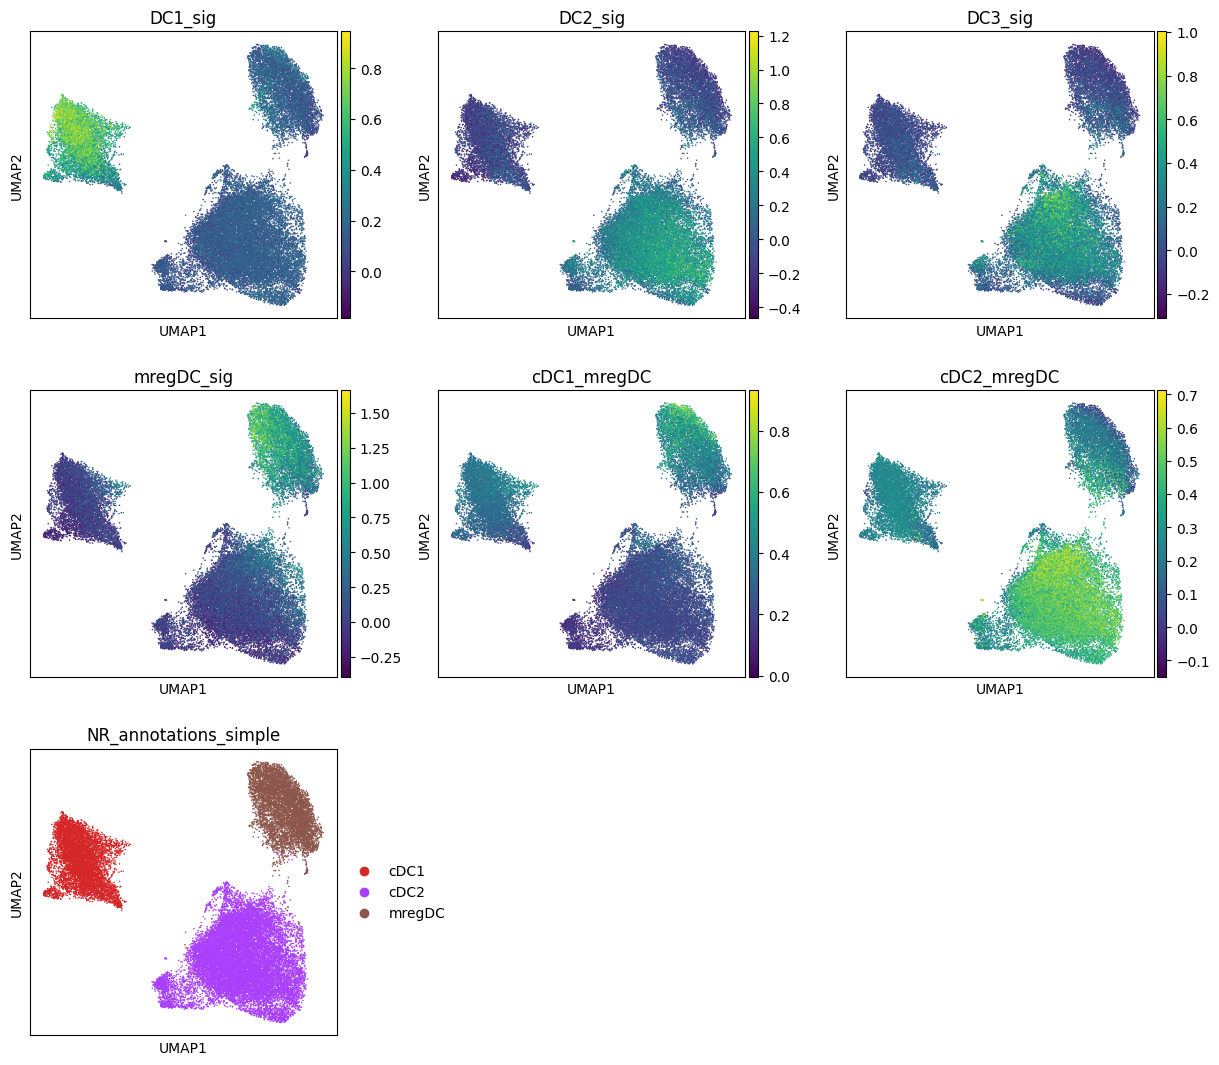

In [25]:
#plotting 
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(data, color=colour_vars, ncols=3, size=5)

In [12]:
colour_vars = ["DC1_sig","DC2_sig","mregDC_sig"]

In [14]:
titles=['cDC1 Score','cDC2 Score','mregDC Score']

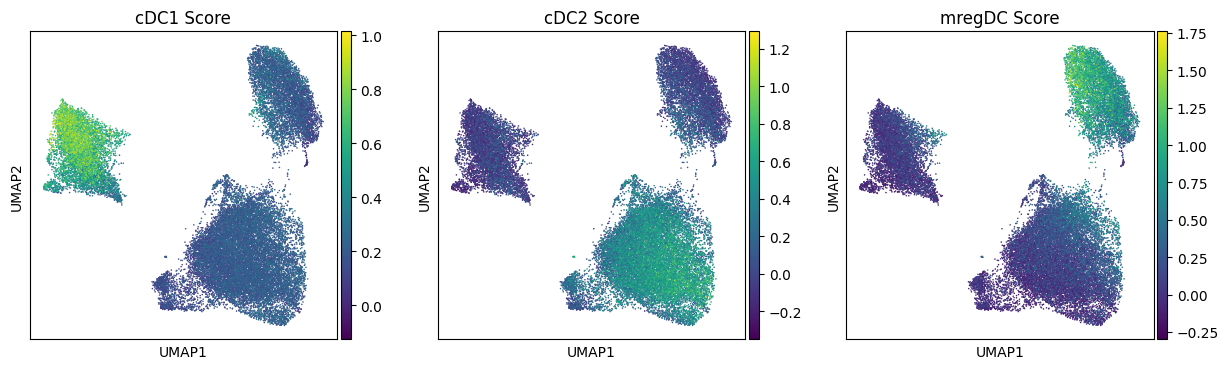

In [16]:
#plotting 
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(data, color=colour_vars, ncols=3, size=5, title=titles)

/scratch/temp/12001575/ipykernel_945504/3507944906.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


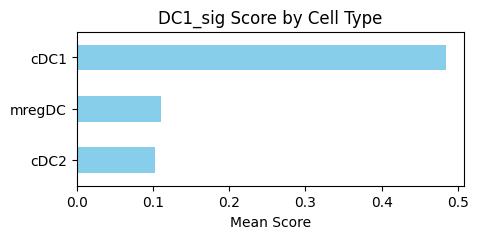

/scratch/temp/12001575/ipykernel_945504/3507944906.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


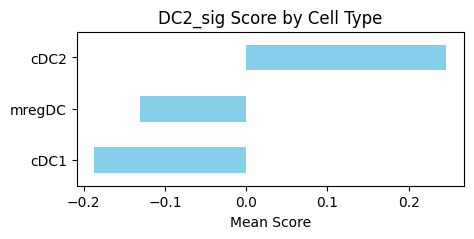

/scratch/temp/12001575/ipykernel_945504/3507944906.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


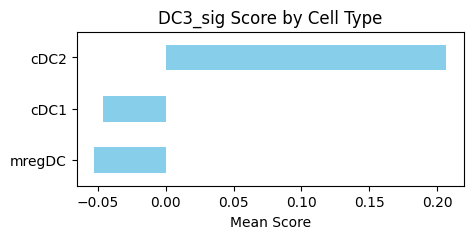

/scratch/temp/12001575/ipykernel_945504/3507944906.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


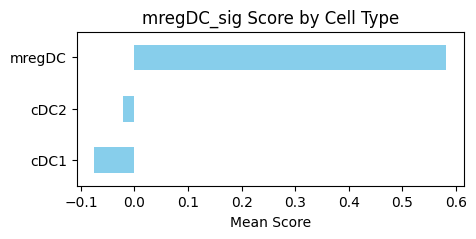

/scratch/temp/12001575/ipykernel_945504/3507944906.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


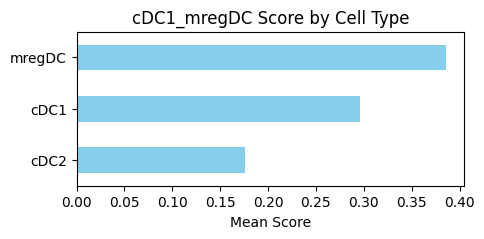

/scratch/temp/12001575/ipykernel_945504/3507944906.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


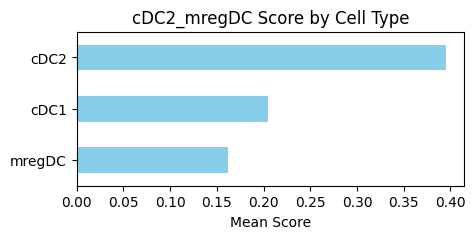

In [27]:
cluster_col = "NR_annotations_simple"

# Loop over each gene set to create a bar plot
for gene_set in gene_sets.keys():
    # Calculate the mean score for each cluster
    mean_scores = data.obs.groupby(cluster_col)[gene_set].mean()
    
    # Plot the mean scores as a horizontal bar plot
    plt.figure(figsize=(5, 2))
    mean_scores.sort_values().plot(kind='barh', color="skyblue")
    plt.xlabel("Mean Score")
    plt.title(f"{gene_set} Score by Cell Type")
    plt.ylabel("")
    plt.show()

# Overlay uptake signature (heat map and per sample as box plots)

In [31]:
#make an object with my sig - see excel file Nikita-mregDC_DEG_summary on i drive
Uptake_sig = ["CCL22","IL4I1","SIRPA","CCR7","CHST11","GPR157","RGS1","BIRC3","TRAF1","CSF2RA","TBC1D13","LAMP3","MREG","PPP1R14A","SPRED2","CD83","TXN","MOB3A","NFKB1","TBC1D4","CDK2","WFDC21P","ARAP2","ZER1","ACSL1","SPINT2","SQSTM1","TBC1D8","JAG1","AC073508.3","BATF","ETV3","BCL2","KIF2A","FSCN1","TNFAIP3","CCDC28B","NR4A3","CYTIP","PLEK","FOXO1","TOMM34","TRAFD1","PPP1R16B","CXCR4","CD40","ENTPD7","CDKN1A","BID","MARCKS","DUSP5","MAP4K4","BCL2L1","ISG20","RNF145","RNF121","GPR132","RASGEF1B","CYRIA","RAB10","CERS6","IL1R1","STK4","CLEC2D","AL390719.1","ZBTB38","IFNGR2","CD274","SLC41A2","NRP2","ANKRD33B","GPR183","POGLUT1","ADORA2A","JADE3","KHDRBS3","CTNNB1","SLCO5A1","NFKB2","RGS2","SEC61B","ZNRF1","RELB","C12orf45","IRF2","EPOP","MXD1","RAB5B","PADI2","DRAM1","MTMR4","EEF2K","GCNT2","RAPH1","BCL2A1","SEC23B","PIM3","ANTXR2","ABTB2","TMEM200A"]    

In [32]:
#score genes
sc.tl.score_genes(data, Uptake_sig, score_name='Uptake_score')

In [33]:
colour_vars = ["Uptake_score","NR_annotations_simple"]

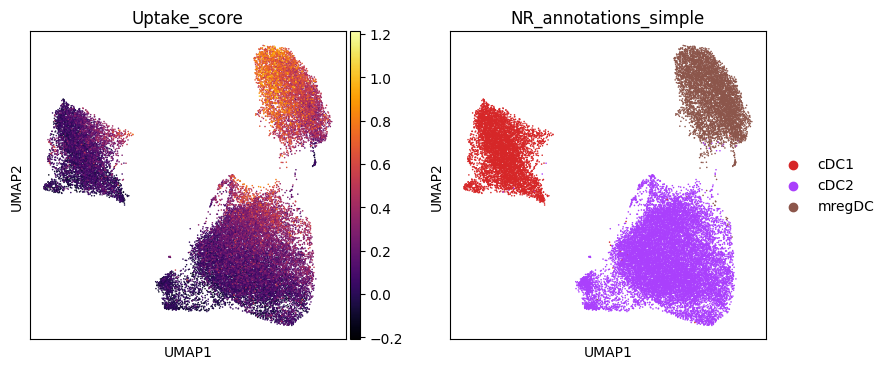

In [35]:
#plotting 
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(data, color=colour_vars, ncols=2, size=5, color_map="inferno")

In [36]:
# Calculate the mean scores for each cluster
cluster_labels = data.obs['NR_annotations_simple']
uptake_scores = data.obs['Uptake_score']

In [37]:
# Create a DataFrame with the mean scores per cluster
scores_df = pd.DataFrame({
    'Uptake_scores': uptake_scores.groupby(cluster_labels).mean(),
})

/scratch/temp/12001575/ipykernel_945504/2766785551.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


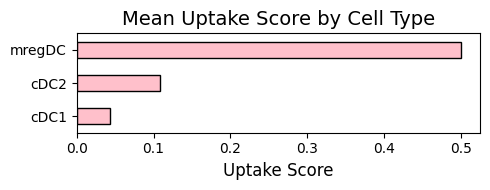

In [42]:
# Plot as a horizontal bar chart
plt.figure(figsize=(5, 2))
scores_df['Uptake_scores'].sort_values().plot.barh(
    color='pink', edgecolor='black', legend=False
)
plt.title("Mean Uptake Score by Cell Type", fontsize=14)
plt.xlabel("Uptake Score", fontsize=12)
plt.ylabel("")
plt.tight_layout()
plt.show()

### plotting score on a per sample basis already done in prism and 2024-11-19_Sig_Overlay.jpynb notebook

# Overlay cytotrace results 

In [29]:
colour_vars = ["CytoTRACE_DC_Predicted_order","NR_annotations_simple"]

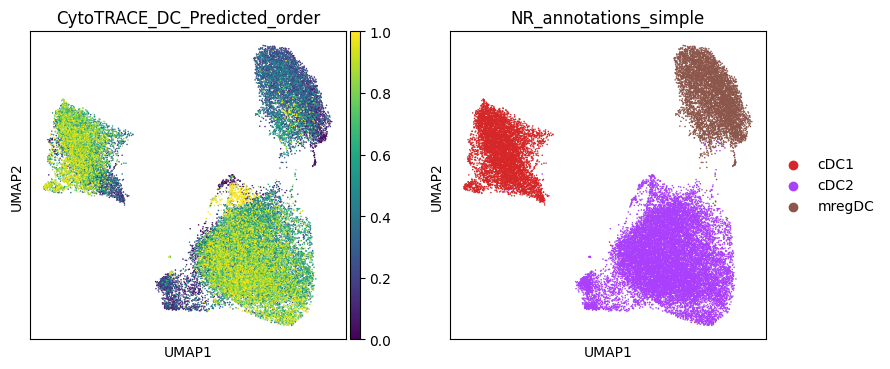

In [30]:
#plotting - cytoTRACE score: 1 --> less diff, 0 --> more diff.
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(data, color=colour_vars, ncols=2, size=5)

# Overlaying markers from Guimaraes et al 2024

In [ ]:
colour_vars = ["CLEC9A","AREG","CD14","FCGR3A","FCER1A","CD207","LAMP3","CXCL2","NR_annotations_simple"]

In [ ]:
#plotting 
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(data, color=colour_vars, ncols=4, size=5, color_map="inferno")